# RuleFit for interpretable Machine Learning


While Deep Learning will probably keep its position as the hottest topic in Machine Learning for the nearer future, we also see a rising interest in white-box models whose calculations and outputs can be interpreted by a human being. Although it might look like this interpretability restrictions severely shrinkens the toolbox of usable algorithms there are still plentiful models that are both human readable and flexible enough for serious data analysis and prediction.  
Some of the better known models that fulfill the requirements are for example [Polynomial Regression](https://en.wikipedia.org/wiki/Polynomial_regression) or [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree). There are also less well known options like [Genetic Programming](https://en.wikipedia.org/wiki/Genetic_programming), Bayesian Additive Regression Trees ([BART](http://www-stat.wharton.upenn.edu/~edgeorge/Research_papers/BART%20June%2008.pdf)) or [Bayesian Treed Models](http://www-stat.wharton.upenn.edu/~edgeorge/Research_papers/treed-models.pdf) of which all, due to their probabilistic construction schemes, require some more dedication to be trained properly.

In this post I want to look at the [RuleFit algorithm by Jerome Friedman](http://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf) that is both interpretable and flexible and which I personally think is a real genius solution to the interpretability-accuracy trade-off that data analysts and scientists will encounter most of the time.  
In short, the core idea of RuleFit is to train a series of diverse Decision Trees, extract all single decision rules from the trees into a matrix of binary dummy variables and run a (penalized) Linear Regression between the explained variable and the original features combined with the dummy matrix.

This is easiest explained through example so for the remainder I will reconstruct the RuleFit algorithm using sklearn's Decision Tree and Linear Model frameworks.

In [29]:
import numpy as np


from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
import matplotlib

## The dataset
I have decided to use the [House Sales in King County](https://www.kaggle.com/harlfoxem/housesalesprediction) dataset from Kaggle since it does not contain missing data and housing price datasets are commonly used as example data for Decision Tree based ML algorihms. As this example is solely to demonstrate the idea and power of RuleFit, I will not perform any feature engineering, except for removing some unnecessary features:

In [30]:
import pandas as pd

df = pd.read_csv("kc_house_data.csv")

#'id' is a unique value for each row, so it's removed to avoid overfit
#'date' is probably too noisy if it's not being split up further into e.g. month, weekday etc.
#'zipcode' might be noisy, too, so I dropped it as well
df.drop(["id", "date", "zipcode"], 1, inplace = True)

#the target variable is house price
X = df.drop("price",1)
y = df["price"]

df.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503


**Side Note**: There are some time-series aspects to this dataset as well, e.g. there could be a latent trend in 'price' due to overall housing market conditions that is not being captured in the data. If this model was meant to be used in the real-world, care should be taken to account for this - especially any form of train-validate-test split (or k-fold cv) must be appropriately adjusted. (see for example [this blog-post](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/))

## How RuleFit works
At first, RuleFit constructs a large amount of if-then rules via Decision Trees and then uses 1/0 dummy variables to mark if a given observation in fulfills that rule or not. Considering the first two rows in the table above, an example rule could state **if sqft_living<=1180 and floors<=1.0** and since row one fulfills that rule, the according dummy for that observation would be $1$, whereas the second row would be marked as $0$
All dummy variables for all observations are then combined into a new dataframe together with the original features and regressed on the target variable ('price' in this example). Normally, a small subset of all rules will be sufficient to get good results, so a penalized version of Linear Regression like Lasso is used to filter out unnecessary rules.

Let's construct a very shallow Decision Tree to visualize what exactly is happending under the hood:

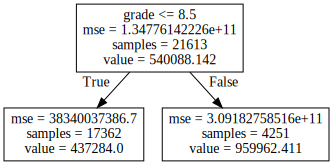

In [31]:
#the target ('price') is a continuous variable so we need a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

dTree = DecisionTreeRegressor(max_depth=1)
dTree.fit(X,y)


from sklearn.tree import export_graphviz
import graphviz
graphviz.Source(export_graphviz(dTree, out_file = None, feature_names = X.columns.tolist()))

### Getting a little technical (not required to understand RuleFit)
The predictive function of this simple tree can be expressed mathematically through a linear combination of indicator-functions:

$$f(X_i)=437284.0\cdot I_{grade\leq8.5}(X_i)+959962.411 \cdot I_{grade>8.5}(X_i)$$

which can be used to predict the sale price for any house in the dataset. Notice that the indicator functions work as set-functions on the two (hypercubic) subsets $d_1 = D|grade\leq8.5$ and $d_2 = D|grade>8.5$ where $d_1\cup d_2=D$ , where $D$ is the Instance Space of all possible realizations of the regressors in $X$ and $d_1\cap d_2=\emptyset$. $D$ could also be identified with $\mathbb{R}^k$ with $k$ being the number of regressors, however this would be a bit sloppy for binary variables or variables that can only take on values on a subset of $\mathbb{R}$.

Now, we got exactly two rules that would be usable for the RuleFit Algorithm:

1) $I_{grade\leq8.5}(X_i)$  
2) $I_{grade>8.5}(X_i)$


Adding a second level of Decision Nodes, the tree extends to:

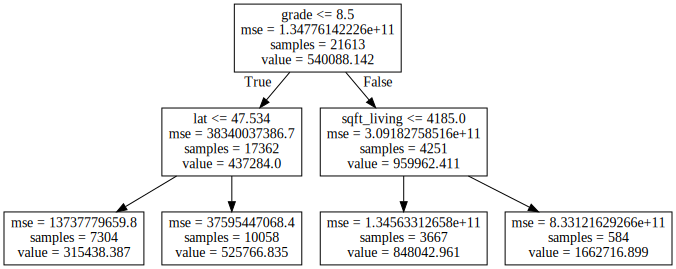

In [32]:
dTree2 = DecisionTreeRegressor(max_depth=2)
dTree2.fit(X,y)

graphviz.Source(export_graphviz(dTree2, out_file = None, feature_names = X.columns.tolist()))

This results in the predictive function

$$f(X_i)=315438.387\cdot I_{grade\leq8.5}(X_i)\cdot I_{lat\leq47.534}(X_i)+525766\cdot I_{grade\leq8.5}(X_i)\cdot I_{lat>47.534}(X_i) + 848042.961 \cdot I_{grade>8.5}(X_i)\cdot I_{sqft_living\leq4185.0}(X_i)+1662716.899 \cdot I_{grade>8.5}(X_i)\cdot I_{sqft_living>4185.0}(X_i)$$

which clearly shows that this notation gets quickly unfeasible for deeper Decision Trees.

Nevertheless, the tree gives us the single rules

1) $I_{grade\leq8.5}(X_i)\cdot I_{lat\leq47.534}(X_i)$  
2) $I_{grade\leq8.5}(X_i)\cdot I_{lat>47.534}(X_i)$  
3) $I_{grade>8.5}(X_i)\cdot I_{sqft_living\leq4185.0}(X_i)$  
4) $I_{grade>8.5}(X_i)\cdot I_{sqft_living>4185.0}(X_i)$  

plus all the rules that can be created by splitting the composite rules into their parts:

5) $I_{grade\leq8.5}(X_i)$  
6) $I_{lat\leq47.534}(X_i)$  
7) $I_{lat>47.534}(X_i)$  
...and so on

### RuleFit in Python with sklearn

In practice, programming RuleFit in Python is pretty simple thanks to the functionalities of sklearn's DecisionTrees (although it needs a minor workaround, the approach is still very straightforward)
Let's use the Decision Tree from above and extract the rules that were created:

In [33]:
pd.DataFrame(dTree2.decision_path(X).toarray()).head(5)

#.decision_path() returns a Sparse Matrix which has to be converted to a numpy-array through
#.toarray() first 

,0,1,2,3,4,5,6
0,1,1,1,0,0,0,0
1,1,1,0,1,0,0,0
2,1,1,0,1,0,0,0
3,1,1,1,0,0,0,0
4,1,1,0,1,0,0,0


The .decision_path(X) method will create a binary matrix marking the nodes that each observation passed by applying the if-then rules in the tree. Notice how each observation passed the root-node (column "0" in the matrix), then the observation in row "0" passed node 1 (grade<=8.5) and ended up in node 2 (lat<=47.534) which is a leaf node.  
The observation in row "1" has the first two nodes in common with the former observation but will end up in node 3  (lat>47.5324)  

**Side note**: The tree is being traversed in a depth-first manner and the node id-numbers are assigned accordingly)


That way, every observation in the dataset receives 0/1-classifications based on the nodes it passed on its way through the tree. This indicates wether the sample matches the rules created by the tree or not. Notice that the .decision_path() method does not extract all possible rules from the tree but only the combined rules among the decision paths up to a given node. While there are more rules to extract, the current solution is much easier to implement and faster to run. Additionally, more rules can always be created by using an ensemble of trees and combining the resulting dummy-matrices.

Next comes the question about how to best create a whole lot of different rules. The main reason for applying RuleFit in the first place was to create an interpretable output, so for a human interactor it would be easiest if the rules were rather short. That means that we prefer shallow Decision Trees, which makes Gradient Boosting a good choice for RuleFit as it creates an ensemble of smaller trees. Nevertheless, all algorithms that generate lots of diverse Decision Trees work for RuleFit, even a simple for-loop of randomized (Extra) Decision Trees.  
(I will spare the use of Tree Ensembles for rule creation until next time and continue with a single tree for simplicity)

The final ingredient before running the Linear Model is to merge the dummy dataframe with the original features - that's because Decision Trees are having trouble to deal with highly linear data. Thus, adding the original features will enable the (linear) Regression Algorithm to fix that issue for RuleFit.

In [34]:
pd.concat([X.reset_index(drop=True),pd.DataFrame(dTree2.decision_path(X).toarray())],1).head(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,long,sqft_living15,sqft_lot15,0,1,2,3,4,5,6
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,-122.257,1340,5650,1,1,1,0,0,0,0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,-122.319,1690,7639,1,1,0,1,0,0,0
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,-122.233,2720,8062,1,1,0,1,0,0,0
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,-122.393,1360,5000,1,1,1,0,0,0,0
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,-122.045,1800,7503,1,1,0,1,0,0,0


To finish the example, let's combine all the steps above using one slightly deeper Decision Tree:

In [35]:
#1) fit the regression tree
dTree3 = DecisionTreeRegressor(max_depth = 4)
dTree3.fit(X,y)


#2) extract rules and combine with original features (note that I dropped the first rule column which
#    marks the root node, so it contains no differentiating information)
Xrules = pd.concat([X.reset_index(drop=True),pd.DataFrame(dTree3.decision_path(X).toarray()).iloc[:,1:]],1)


#3) fit a linear model on the combined data frame. Plain Linear Regression would work here as well since
#   the amount of rules is still very small - that changes once we merge some 1000s of rules into one matrix
linear_model = Lasso()
linear_model.fit(Xrules, y)


#3.5) predict unseen data. This should be rather self-explanatory, just replace the 'X'-DataFrame in
#     step 2) with the unseen data and use linear_model.predict() to perform predictions

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

This concludes this short introduction into the RuleFit-algorithm. In my next post, I will show you how to create a much higher amount of different rules via Gradient Boosting and how to extract actual rules from the rather abstract binary-matrices.